In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import pandas as pd 
import math 
from tqdm import tqdm


In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [4]:
!unzip gdrive/MyDrive/Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/neutrophil/BNE_44875.jpg  
  inflating: Dataset/neutrophil/BNE_448776.jpg  
  inflating: Dataset/neutrophil/BNE_449730.jpg  
  inflating: Dataset/neutrophil/BNE_449915.jpg  
  inflating: Dataset/neutrophil/BNE_450464.jpg  
  inflating: Dataset/neutrophil/BNE_451701.jpg  
  inflating: Dataset/neutrophil/BNE_451729.jpg  
  inflating: Dataset/neutrophil/BNE_453088.jpg  
  inflating: Dataset/neutrophil/BNE_454089.jpg  
  inflating: Dataset/neutrophil/BNE_454943.jpg  
  inflating: Dataset/neutrophil/BNE_455080.jpg  
  inflating: Dataset/neutrophil/BNE_4555.jpg  
  inflating: Dataset/neutrophil/BNE_455636.jpg  
  inflating: Dataset/neutrophil/BNE_45575.jpg  
  inflating: Dataset/neutrophil/BNE_456543.jpg  
  inflating: Dataset/neutrophil/BNE_45687.jpg  
  inflating: Dataset/neutrophil/BNE_45719.jpg  
  inflating: Dataset/neutrophil/BNE_45721.jpg  
  inflating: Dataset/neutrophil/BNE_458029.jpg  
  inflating: Dataset/neut

In [5]:
from os import listdir
import cv2
import numpy as np

# Root Folder Name
FOLDER_NAME = 'Dataset'
# Class Folders
folders = listdir(FOLDER_NAME)
NR_CLASSES = len(folders)
# Walk over folders
data_X, data_Y = [], []
for i in range(NR_CLASSES):
    folder = folders[i]
    print('Folder', i+1, '-', folder)
    images = listdir(FOLDER_NAME + '/' + folder)
    # Walk over images
    for image in images:
        path = FOLDER_NAME + '/' + folder + '/' + image
        # Process Image
        raw = cv2.imread(path)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(gray, (32, 32))
        # Add to data
        data_X.append(img.flatten())
        data_Y.append(i)
# Convert to numpy arrays
X = np.array(data_X)
Y = np.array(data_Y).reshape([-1, 1])
# Verify sizes match
print('\nX and Y equal:', len(X) == len(Y))
print('Total training examples:', len(X))
print(X.shape)
print(Y.shape)

Folder 1 - neutrophil
Folder 2 - ig
Folder 3 - lymphocyte
Folder 4 - basophil
Folder 5 - erythroblast
Folder 6 - monocyte
Folder 7 - eosinophil
Folder 8 - platelet

X and Y equal: True
Total training examples: 17092
(17092, 1024)
(17092, 1)


In [6]:
def convolution(image, filt, bias, s=1):
    '''
    Confolves `filt` over `image` using stride `s`
    '''
    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    n_c, in_dim, _ = image.shape # image dimensions
    
    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
    
    # ensure that the filter dimensions match the dimensions of the input image
    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
    
    out = np.zeros((n_f,out_dim,out_dim)) # create the matrix to hold the values of the convolution operation
    
    # convolve each filter over the image
    for curr_f in range(n_f):
        curr_y = out_y = 0
        # move filter vertically across the image
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            # move filter horizontally across the image 
            while curr_x + f <= in_dim:
                # perform the convolution operation and add the bias
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        #print('Conv is working')
    return out

In [7]:
def maxpool(image, f=2, s=2):
    
    #Downsample input `image` using a kernel size of `f` and a stride of `s`
    
    n_c, h_prev, w_prev = image.shape
    
    # calculate output dimensions after the maxpooling operation.
    h = int((h_prev - f)/s)+1 
    w = int((w_prev - f)/s)+1
    
    # create a matrix to hold the values of the maxpooling operation.
    downsampled = np.zeros((n_c, h, w)) 
    
    # slide the window over every part of the image using stride s. Take the maximum value at each step.
    for i in range(n_c):
        curr_y = out_y = 0
        # slide the max pooling window vertically across the image
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            # slide the max pooling window horizontally across the image
            while curr_x + f <= w_prev:
                # choose the maximum value within the window at each step and store it to the output matrix
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    #print('max pooling is working')        
    return downsampled

In [8]:
def softmax(raw_preds):
    '''
    pass raw predictions through softmax activation function
    '''
    out = np.exp(raw_preds) # exponentiate vector of raw predictions
    return out/np.sum(out) # divide the exponentiated vector by its sum. All values in the output sum to 1.

In [9]:
def categoricalCrossEntropy(probs, label):
    '''
    calculate the categorical cross-entropy loss of the predictions
    '''
    return -np.sum(label * np.log(probs)) # Multiply the desired output label by the log of the prediction, then sum all values in the vector


In [10]:
def initializeFilter(size, scale = 1.0):
    '''
    Initialize filter using a normal distribution with and a 
    standard deviation inversely proportional the square root of the number of units
    '''
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

def initializeWeight(size):
    '''
    Initialize weights with a random normal distribution
    '''
    return np.random.standard_normal(size=size) * 0.01

In [11]:
def convolutionBackward(dconv_prev, conv_in, filt, s):
    '''
    Backpropagation through a convolutional layer. 
    '''
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias

def nanargmax(arr):
    '''
    return index of the largest non-nan value in the array. Output is an ordered pair tuple
    '''
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 

def maxpoolBackward(dpool, orig, f, s):
    '''
    Backpropagation through a maxpooling layer. The gradients are passed through the indices of greatest value in the original maxpooling during the forward step.
    '''
    (n_c, orig_dim, _) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window
                (a, b) = nanargmax(orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f])
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]
                
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return dout

In [12]:
def conv(image, label, params, conv_s, pool_f, pool_s):
    
    [f1, f2, w3, w4, b1, b2, b3, b4] = params 
    
    ################################################
    ############## Forward Operation ###############
    ################################################
    conv1 = convolution(image, f1, b1, conv_s) # convolution operation
    conv1[conv1<=0] = 0 # pass through ReLU non-linearity
    
    conv2 = convolution(conv1, f2, b2, conv_s) # second convolution operation
    conv2[conv2<=0] = 0 # pass through ReLU non-linearity
    
    pooled = maxpool(conv2, pool_f, pool_s) # maxpooling operation
    
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer
    
    z = w3.dot(fc) + b3 # first dense layer
    z[z<=0] = 0 # pass through ReLU non-linearity
    
    out = w4.dot(z) + b4 # second dense layer
     
    probs = softmax(out) # predict class probabilities with the softmax activation function
    
    ################################################
    #################### Loss ######################
    ################################################
    
    loss = categoricalCrossEntropy(probs, label) # categorical cross-entropy loss
        
    ################################################
    ############# Backward Operation ###############
    ################################################
    dout = probs - label # derivative of loss w.r.t. final dense layer output
    dw4 = dout.dot(z.T) # loss gradient of final dense layer weights
    db4 = np.sum(dout, axis = 1).reshape(b4.shape) # loss gradient of final dense layer biases
    
    dz = w4.T.dot(dout) # loss gradient of first dense layer outputs 
    dz[z<=0] = 0 # backpropagate through ReLU 
    dw3 = dz.dot(fc.T)
    db3 = np.sum(dz, axis = 1).reshape(b3.shape)
    
    dfc = w3.T.dot(dz) # loss gradients of fully-connected layer (pooling layer)
    dpool = dfc.reshape(pooled.shape) # reshape fully connected into dimensions of pooling layer
    
    dconv2 = maxpoolBackward(dpool, conv2, pool_f, pool_s) # backprop through the max-pooling layer(only neurons with highest activation in window get updated)
    dconv2[conv2<=0] = 0 # backpropagate through ReLU
    
    dconv1, df2, db2 = convolutionBackward(dconv2, conv1, f2, conv_s) # backpropagate previous gradient through second convolutional layer.
    dconv1[conv1<=0] = 0 # backpropagate through ReLU
    
    dimage, df1, db1 = convolutionBackward(dconv1, image, f1, conv_s) # backpropagate previous gradient through first convolutional layer.
    
    grads = [df1, df2, dw3, dw4, db1, db2, db3, db4] 
    
    return grads, loss

In [13]:
def adamGD(batch, num_classes, lr, dim, n_c, beta1, beta2, params, cost):
    '''
    update the parameters through Adam gradient descnet.
    '''
    [f1, f2, w3, w4, b1, b2, b3, b4] = params
    
    X = batch[:,0:-1] # get batch inputs
    X = X.reshape(len(batch), n_c, dim, dim)
    Y = batch[:,-1] # get batch labels
    
    cost_ = 0
    batch_size = len(batch)
    
    # initialize gradients and momentum,RMS params
    df1 = np.zeros(f1.shape)
    df2 = np.zeros(f2.shape)
    dw3 = np.zeros(w3.shape)
    dw4 = np.zeros(w4.shape)
    db1 = np.zeros(b1.shape)
    db2 = np.zeros(b2.shape)
    db3 = np.zeros(b3.shape)
    db4 = np.zeros(b4.shape)
    
    v1 = np.zeros(f1.shape)
    v2 = np.zeros(f2.shape)
    v3 = np.zeros(w3.shape)
    v4 = np.zeros(w4.shape)
    bv1 = np.zeros(b1.shape)
    bv2 = np.zeros(b2.shape)
    bv3 = np.zeros(b3.shape)
    bv4 = np.zeros(b4.shape)
    
    s1 = np.zeros(f1.shape)
    s2 = np.zeros(f2.shape)
    s3 = np.zeros(w3.shape)
    s4 = np.zeros(w4.shape)
    bs1 = np.zeros(b1.shape)
    bs2 = np.zeros(b2.shape)
    bs3 = np.zeros(b3.shape)
    bs4 = np.zeros(b4.shape)
    
    for i in range(batch_size):
        
        x = X[i]
        y = np.eye(num_classes)[int(Y[i])].reshape(num_classes, 1) # convert label to one-hot
        
        # Collect Gradients for training example
        grads, loss = conv(x, y, params, 1, 2, 2)
        [df1_, df2_, dw3_, dw4_, db1_, db2_, db3_, db4_] = grads
        
        df1+=df1_
        db1+=db1_
        df2+=df2_
        db2+=db2_
        dw3+=dw3_
        db3+=db3_
        dw4+=dw4_
        db4+=db4_

        cost_+= loss

    # Parameter Update  
        
    v1 = beta1*v1 + (1-beta1)*df1/batch_size # momentum update
    s1 = beta2*s1 + (1-beta2)*(df1/batch_size)**2 # RMSProp update
    f1 -= lr * v1/np.sqrt(s1+1e-7) # combine momentum and RMSProp to perform update with Adam
    
    bv1 = beta1*bv1 + (1-beta1)*db1/batch_size
    bs1 = beta2*bs1 + (1-beta2)*(db1/batch_size)**2
    b1 -= lr * bv1/np.sqrt(bs1+1e-7)
   
    v2 = beta1*v2 + (1-beta1)*df2/batch_size
    s2 = beta2*s2 + (1-beta2)*(df2/batch_size)**2
    f2 -= lr * v2/np.sqrt(s2+1e-7)
                       
    bv2 = beta1*bv2 + (1-beta1) * db2/batch_size
    bs2 = beta2*bs2 + (1-beta2)*(db2/batch_size)**2
    b2 -= lr * bv2/np.sqrt(bs2+1e-7)
    
    v3 = beta1*v3 + (1-beta1) * dw3/batch_size
    s3 = beta2*s3 + (1-beta2)*(dw3/batch_size)**2
    w3 -= lr * v3/np.sqrt(s3+1e-7)
    
    bv3 = beta1*bv3 + (1-beta1) * db3/batch_size
    bs3 = beta2*bs3 + (1-beta2)*(db3/batch_size)**2
    b3 -= lr * bv3/np.sqrt(bs3+1e-7)
    
    v4 = beta1*v4 + (1-beta1) * dw4/batch_size
    s4 = beta2*s4 + (1-beta2)*(dw4/batch_size)**2
    w4 -= lr * v4 / np.sqrt(s4+1e-7)
    
    bv4 = beta1*bv4 + (1-beta1)*db4/batch_size
    bs4 = beta2*bs4 + (1-beta2)*(db4/batch_size)**2
    b4 -= lr * bv4 / np.sqrt(bs4+1e-7)
    

    cost_ = cost_/batch_size
    cost.append(cost_)

    params = [f1, f2, w3, w4, b1, b2, b3, b4]
    #print ("parameters", params)
    #print ("f2", params[1])

    print ("Cost", cost)
    return params, cost

In [14]:
#####################################################
##################### Training ######################
#####################################################

def train(num_classes, lr, beta1, beta2, img_dim, img_depth, f, num_filt1, num_filt2, batch_size, num_epochs):

    # Get training data
    m =1000
    
    data = np.hstack((X,Y))

    np.random.shuffle(data)
    data_train = round(0.6*len(data))
    data_valid = round(data_train+0.2*len(data))
    train_x = X[:data_train]
    valid_x = X[data_train:data_valid]
    test_x = X[data_valid:]
    #train_data = data[:m]

    train_y = Y[:data_train]
    valid_y = Y[data_train:data_valid]
    test_y = Y[data_valid:]

    train_data = np.hstack((train_x,train_y))
    valid_data = np.hstack((valid_x,valid_y))
    test_data = np.hstack((test_x,test_y))

    #np.random.shuffle(train_data)
    #np.random.shuffle(valid_data)

    train_data = train_data[:m]
    valid_data = valid_data[:m]
    test_data = test_data[:m]


    ## Initializing all the parameters
    f1, f2, w3, w4 = (num_filt1 ,img_depth,f,f), (num_filt2 ,num_filt1,f,f), (128,720), (8, 128)
    f1 = initializeFilter(f1)
    f2 = initializeFilter(f2)
    w3 = initializeWeight(w3)
    w4 = initializeWeight(w4)

    b1 = np.zeros((f1.shape[0],1))
    b2 = np.zeros((f2.shape[0],1))
    b3 = np.zeros((w3.shape[0],1))
    b4 = np.zeros((w4.shape[0],1))

    params = [f1, f2, w3, w4, b1, b2, b3, b4]

    cost = []
    valid_cost = []
    test_cost = []

    print("LR:"+str(lr)+", Batch Size:"+str(batch_size))

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]

        np.random.shuffle(valid_data)
        batches1 = [valid_data[k:k + batch_size] for k in range(0, valid_data.shape[0], batch_size)]

        np.random.shuffle(test_data)
        batches2 = [test_data[k:k + batch_size] for k in range(0, test_data.shape[0], batch_size)]

        t = tqdm(batches)
        t1 = tqdm(batches1)
        t2 = tqdm(batches2)
        for x,batch in enumerate(t):
            params, cost = adamGD(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, cost)
            t.set_description("Cost: %.2f" % (cost[-1]))

        for x,batch in enumerate(t1):
            params1, valid_cost = adamGD(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, valid_cost)
            t1.set_description("Valid_Cost: %.2f" % (valid_cost[-1]))   
        
        for x,batch in enumerate(t2):
            params2, test_cost = adamGD(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, test_cost)
            t2.set_description("Test_Cost: %.2f" % (test_cost[-1]))
        
    print ("parameters", params)
    #print ("f2", params[1])


    
       
    return params, cost,valid_cost,test_cost

In [15]:
parameters,cost,valid_cost,test_cost = train(num_classes = 8, lr = 0.001, beta1 = 0.95, beta2 = 0.99, img_dim = 32, img_depth = 1, f = 5, num_filt1 = 8, num_filt2 = 5, batch_size = 100, num_epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

LR:0.001, Batch Size:100


Cost: 2.06:  10%|█         | 1/10 [00:29<04:22, 29.18s/it]

Cost [2.057943201457566]


Cost: 1.28:  20%|██        | 2/10 [00:57<03:51, 28.90s/it]

Cost [2.057943201457566, 1.2776639134329035]


Cost: 0.53:  30%|███       | 3/10 [01:25<03:20, 28.70s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924]


Cost: 0.09:  40%|████      | 4/10 [01:56<02:55, 29.31s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903]


Cost: 0.01:  50%|█████     | 5/10 [02:24<02:24, 28.97s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315]


Cost: 0.00:  60%|██████    | 6/10 [02:52<01:55, 28.75s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674]


Cost: 0.00:  70%|███████   | 7/10 [03:21<01:25, 28.59s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258]


Cost: 0.00:  80%|████████  | 8/10 [03:49<00:56, 28.44s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05]


Cost: 0.00:  90%|█████████ | 9/10 [04:17<00:28, 28.37s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05]


Cost: 0.00: 100%|██████████| 10/10 [04:45<00:00, 28.29s/it]


Cost: 0.00: 100%|██████████| 10/10 [04:45<00:00, 28.55s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05]



Valid_Cost: 13.19:  10%|█         | 1/10 [05:13<47:03, 313.71s/it]

Cost [13.187859651192474]


Valid_Cost: 8.21:  20%|██        | 2/10 [05:41<30:24, 228.07s/it]

Cost [13.187859651192474, 8.213480764642828]


Valid_Cost: 4.48:  30%|███       | 3/10 [06:10<19:36, 168.11s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095]


Valid_Cost: 2.09:  40%|████      | 4/10 [06:38<12:36, 126.11s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607]


Valid_Cost: 1.02:  50%|█████     | 5/10 [07:06<08:03, 96.74s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676]


Valid_Cost: 0.50:  60%|██████    | 6/10 [07:34<05:04, 76.14s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917]


Valid_Cost: 0.22:  70%|███████   | 7/10 [08:02<03:05, 61.79s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822]


Valid_Cost: 0.09:  80%|████████  | 8/10 [08:31<01:43, 51.70s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147]


Valid_Cost: 0.03:  90%|█████████ | 9/10 [08:59<00:44, 44.59s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174]


Valid_Cost: 0.01: 100%|██████████| 10/10 [09:27<00:00, 56.73s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085]



Test_Cost: 11.33:  10%|█         | 1/10 [09:55<1:29:18, 595.36s/it]

Cost [11.328780128969221]


Test_Cost: 8.64:  20%|██        | 2/10 [10:23<56:41, 425.23s/it]  

Cost [11.328780128969221, 8.643247905463005]


Test_Cost: 6.51:  30%|███       | 3/10 [10:52<35:43, 306.18s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515]


Test_Cost: 4.78:  40%|████      | 4/10 [11:20<22:16, 222.81s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471]


Test_Cost: 3.50:  50%|█████     | 5/10 [11:48<13:42, 164.43s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956]


Test_Cost: 2.59:  60%|██████    | 6/10 [12:16<08:14, 123.55s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885]


Test_Cost: 2.02:  70%|███████   | 7/10 [12:44<04:44, 94.93s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722]


Test_Cost: 1.69:  80%|████████  | 8/10 [13:12<02:29, 74.90s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332]


Test_Cost: 1.51:  90%|█████████ | 9/10 [13:41<01:00, 60.87s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509]


Cost: 2.17:  10%|█         | 1/10 [00:28<04:13, 28.15s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585]


Cost: 1.79:  20%|██        | 2/10 [00:56<03:45, 28.15s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792]


Cost: 1.59:  30%|███       | 3/10 [01:24<03:17, 28.15s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255]


Cost: 1.30:  40%|████      | 4/10 [01:52<02:49, 28.25s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995]


Cost: 0.94:  50%|█████     | 5/10 [02:21<02:21, 28.23s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728]


Cost: 0.60:  60%|██████    | 6/10 [02:49<01:52, 28.24s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142]


Cost: 0.27:  70%|███████   | 7/10 [03:17<01:24, 28.29s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847]


Cost: 0.09:  80%|████████  | 8/10 [03:46<00:56, 28.31s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517]


Cost: 0.02:  90%|█████████ | 9/10 [04:14<00:28, 28.27s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745]


Cost: 0.00: 100%|██████████| 10/10 [04:42<00:00, 28.28s/it]


Cost: 0.00: 100%|██████████| 10/10 [04:42<00:00, 28.26s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551]



Valid_Cost: 8.34:  10%|█         | 1/10 [05:11<46:39, 311.04s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023]


Valid_Cost: 5.78:  20%|██        | 2/10 [05:39<30:09, 226.22s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389]


Valid_Cost: 3.80:  30%|███       | 3/10 [06:07<19:27, 166.84s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625]


Valid_Cost: 2.40:  40%|████      | 4/10 [06:35<12:31, 125.26s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048]


Valid_Cost: 1.47:  50%|█████     | 5/10 [07:04<08:01, 96.20s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022]


Valid_Cost: 0.94:  60%|██████    | 6/10 [07:32<05:03, 75.78s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489]


Valid_Cost: 0.54:  70%|███████   | 7/10 [08:00<03:04, 61.55s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977]


Valid_Cost: 0.25:  80%|████████  | 8/10 [08:29<01:43, 51.69s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957]


Valid_Cost: 0.09:  90%|█████████ | 9/10 [08:58<00:44, 44.83s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797]


Valid_Cost: 0.03: 100%|██████████| 10/10 [09:26<00:00, 56.66s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787]



Test_Cost: 7.92:  10%|█         | 1/10 [09:54<1:29:13, 594.78s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886]


Test_Cost: 6.05:  20%|██        | 2/10 [10:22<56:38, 424.79s/it]  

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922]


Test_Cost: 4.55:  30%|███       | 3/10 [10:51<35:40, 305.83s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209]


Test_Cost: 3.38:  40%|████      | 4/10 [11:19<22:15, 222.56s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414]


Test_Cost: 2.53:  50%|█████     | 5/10 [11:47<13:41, 164.27s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404]


Test_Cost: 1.94:  60%|██████    | 6/10 [12:15<08:13, 123.45s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807]


Test_Cost: 1.55:  70%|███████   | 7/10 [12:44<04:44, 94.90s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297]


Test_Cost: 1.34:  80%|████████  | 8/10 [13:12<02:29, 74.90s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519]


Test_Cost: 1.12:  90%|█████████ | 9/10 [13:40<01:00, 60.88s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754]


Cost: 1.61:  10%|█         | 1/10 [00:28<04:14, 28.30s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361]


Cost: 1.31:  20%|██        | 2/10 [00:56<03:46, 28.30s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302]


Cost: 1.13:  30%|███       | 3/10 [01:24<03:18, 28.29s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993]


Cost: 0.89:  40%|████      | 4/10 [01:53<02:49, 28.26s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615]


Cost: 0.61:  50%|█████     | 5/10 [02:21<02:21, 28.25s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031]


Cost: 0.35:  60%|██████    | 6/10 [02:49<01:53, 28.26s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104]


Cost: 0.16:  70%|███████   | 7/10 [03:17<01:24, 28.27s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811]


Cost: 0.06:  80%|████████  | 8/10 [03:46<00:56, 28.31s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048]


Cost: 0.02:  90%|█████████ | 9/10 [04:14<00:28, 28.28s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887]


Cost: 0.00: 100%|██████████| 10/10 [04:42<00:00, 28.31s/it]


Cost: 0.00: 100%|██████████| 10/10 [04:42<00:00, 28.29s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457]



Valid_Cost: 8.98:  10%|█         | 1/10 [05:11<46:42, 311.41s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584]


Valid_Cost: 6.88:  20%|██        | 2/10 [05:39<30:11, 226.47s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215]


Valid_Cost: 5.12:  30%|███       | 3/10 [06:08<19:29, 167.05s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323]


Valid_Cost: 3.63:  40%|████      | 4/10 [06:36<12:32, 125.39s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122]


Valid_Cost: 2.50:  50%|█████     | 5/10 [07:04<08:01, 96.26s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076]


Valid_Cost: 1.66:  60%|██████    | 6/10 [07:32<05:03, 75.84s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927]


Valid_Cost: 1.10:  70%|███████   | 7/10 [08:01<03:04, 61.57s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166]


Valid_Cost: 0.76:  80%|████████  | 8/10 [08:29<01:43, 51.57s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126]


Valid_Cost: 0.52:  90%|█████████ | 9/10 [08:57<00:44, 44.59s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179]


Valid_Cost: 0.31: 100%|██████████| 10/10 [09:25<00:00, 56.59s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966]



Test_Cost: 4.95:  10%|█         | 1/10 [09:54<1:29:06, 594.05s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658]


Test_Cost: 3.90:  20%|██        | 2/10 [10:22<56:34, 424.32s/it]  

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812]


Test_Cost: 3.07:  30%|███       | 3/10 [10:50<35:38, 305.52s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292]


Test_Cost: 2.38:  40%|████      | 4/10 [11:18<22:14, 222.37s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245]


Test_Cost: 1.87:  50%|█████     | 5/10 [11:47<13:40, 164.12s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071]


Test_Cost: 1.50:  60%|██████    | 6/10 [12:15<08:13, 123.41s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839]


Test_Cost: 1.26:  70%|███████   | 7/10 [12:43<04:44, 94.85s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934]


Test_Cost: 1.06:  80%|████████  | 8/10 [13:12<02:29, 74.90s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399]


Test_Cost: 0.84:  90%|█████████ | 9/10 [13:40<01:00, 60.96s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463]


Cost: 1.37:  10%|█         | 1/10 [00:28<04:15, 28.35s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814]


Cost: 1.09:  20%|██        | 2/10 [00:56<03:46, 28.32s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513]


Cost: 0.92:  30%|███       | 3/10 [01:24<03:18, 28.31s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284]


Cost: 0.75:  40%|████      | 4/10 [01:53<02:49, 28.28s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045]


Cost: 0.57:  50%|█████     | 5/10 [02:21<02:21, 28.31s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737]


Cost: 0.40:  60%|██████    | 6/10 [02:49<01:53, 28.29s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085]


Cost: 0.25:  70%|███████   | 7/10 [03:18<01:24, 28.30s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926]


Cost: 0.13:  80%|████████  | 8/10 [03:46<00:56, 28.30s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568]


Cost: 0.06:  90%|█████████ | 9/10 [04:14<00:28, 28.26s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787]


Cost: 0.02: 100%|██████████| 10/10 [04:42<00:00, 28.27s/it]


Cost: 0.02: 100%|██████████| 10/10 [04:42<00:00, 28.28s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423]



Valid_Cost: 7.10:  10%|█         | 1/10 [05:11<46:39, 311.09s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571]


Valid_Cost: 5.77:  20%|██        | 2/10 [05:39<30:10, 226.26s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784]


Valid_Cost: 4.53:  30%|███       | 3/10 [06:07<19:28, 166.90s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347]


Valid_Cost: 3.51:  40%|████      | 4/10 [06:35<12:31, 125.27s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827]


Valid_Cost: 2.66:  50%|█████     | 5/10 [07:04<08:00, 96.18s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814]


Valid_Cost: 1.97:  60%|██████    | 6/10 [07:32<05:03, 75.80s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352]


Valid_Cost: 1.46:  70%|███████   | 7/10 [08:00<03:04, 61.49s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706]


Valid_Cost: 1.08:  80%|████████  | 8/10 [08:28<01:43, 51.51s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595]


Valid_Cost: 0.82:  90%|█████████ | 9/10 [08:57<00:44, 44.53s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553]


Valid_Cost: 0.58: 100%|██████████| 10/10 [09:25<00:00, 56.58s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069]



Test_Cost: 4.07:  10%|█         | 1/10 [09:54<1:29:06, 594.08s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665]


Test_Cost: 3.22:  20%|██        | 2/10 [10:22<56:34, 424.37s/it]  

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418]


Test_Cost: 2.55:  30%|███       | 3/10 [10:50<35:39, 305.58s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486]


Test_Cost: 2.04:  40%|████      | 4/10 [11:19<22:14, 222.38s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297]


Test_Cost: 1.64:  50%|█████     | 5/10 [11:47<13:40, 164.16s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853]


Test_Cost: 1.38:  60%|██████    | 6/10 [12:15<08:13, 123.42s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222]


Test_Cost: 1.19:  70%|███████   | 7/10 [12:44<04:44, 94.91s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994]


Test_Cost: 0.89:  80%|████████  | 8/10 [13:12<02:29, 74.92s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354]


Test_Cost: 0.50:  90%|█████████ | 9/10 [13:40<01:00, 60.91s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303]


Cost: 3.39:  10%|█         | 1/10 [00:28<04:14, 28.27s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612]


Cost: 2.01:  20%|██        | 2/10 [00:56<03:45, 28.25s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509]


Cost: 1.23:  30%|███       | 3/10 [01:24<03:17, 28.22s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968]


Cost: 0.86:  40%|████      | 4/10 [01:52<02:49, 28.26s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594]


Cost: 0.61:  50%|█████     | 5/10 [02:21<02:21, 28.24s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321]


Cost: 0.42:  60%|██████    | 6/10 [02:49<01:52, 28.24s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612]


Cost: 0.25:  70%|███████   | 7/10 [03:17<01:24, 28.18s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373]


Cost: 0.13:  80%|████████  | 8/10 [03:45<00:56, 28.25s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763]


Cost: 0.05:  90%|█████████ | 9/10 [04:13<00:28, 28.21s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.02: 100%|██████████| 10/10 [04:42<00:00, 28.24s/it]


Cost: 0.02: 100%|██████████| 10/10 [04:42<00:00, 28.23s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544


Valid_Cost: 9.54:  10%|█         | 1/10 [05:10<46:34, 310.45s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942]


Valid_Cost: 7.40:  20%|██        | 2/10 [05:38<30:06, 225.76s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081]


Valid_Cost: 5.57:  30%|███       | 3/10 [06:06<19:25, 166.50s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467]


Valid_Cost: 4.09:  40%|████      | 4/10 [06:35<12:30, 125.02s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952]


Valid_Cost: 3.01:  50%|█████     | 5/10 [07:03<08:00, 96.01s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775]


Valid_Cost: 2.17:  60%|██████    | 6/10 [07:31<05:02, 75.69s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304]


Valid_Cost: 1.61:  70%|███████   | 7/10 [08:00<03:04, 61.51s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943]


Valid_Cost: 1.25:  80%|████████  | 8/10 [08:28<01:43, 51.56s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471]


Valid_Cost: 1.05:  90%|█████████ | 9/10 [08:56<00:44, 44.58s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756]


Valid_Cost: 0.84: 100%|██████████| 10/10 [09:24<00:00, 56.50s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885]



Test_Cost: 2.64:  10%|█         | 1/10 [09:53<1:28:59, 593.30s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703]


Test_Cost: 2.05:  20%|██        | 2/10 [10:21<56:30, 423.76s/it]  

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166]


Test_Cost: 1.63:  30%|███       | 3/10 [10:49<35:36, 305.19s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437]


Test_Cost: 1.40:  40%|████      | 4/10 [11:18<22:12, 222.14s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132]


Test_Cost: 1.26:  50%|█████     | 5/10 [11:46<13:39, 163.98s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627]


Test_Cost: 1.00:  60%|██████    | 6/10 [12:14<08:13, 123.26s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438]


Test_Cost: 0.65:  70%|███████   | 7/10 [12:43<04:44, 94.76s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104]


Test_Cost: 0.27:  80%|████████  | 8/10 [13:11<02:29, 74.86s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652]


Test_Cost: 0.06:  90%|█████████ | 9/10 [13:39<01:00, 60.88s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825]


Cost: 7.72:  10%|█         | 1/10 [00:28<04:14, 28.33s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 4.94:  20%|██        | 2/10 [00:56<03:46, 28.27s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 2.91:  30%|███       | 3/10 [01:24<03:17, 28.27s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 1.62:  40%|████      | 4/10 [01:53<02:49, 28.27s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.99:  50%|█████     | 5/10 [02:21<02:21, 28.28s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.67:  60%|██████    | 6/10 [02:49<01:53, 28.28s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.42:  70%|███████   | 7/10 [03:17<01:24, 28.31s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.22:  80%|████████  | 8/10 [03:46<00:56, 28.35s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.09:  90%|█████████ | 9/10 [04:14<00:28, 28.31s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.03: 100%|██████████| 10/10 [04:42<00:00, 28.27s/it]


Cost: 0.03: 100%|██████████| 10/10 [04:42<00:00, 28.28s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544


Valid_Cost: 8.74:  10%|█         | 1/10 [05:11<46:39, 311.09s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 6.84:  20%|██        | 2/10 [05:39<30:09, 226.23s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 5.24:  30%|███       | 3/10 [06:07<19:27, 166.84s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 3.92:  40%|████      | 4/10 [06:35<12:31, 125.28s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 2.86:  50%|█████     | 5/10 [07:03<08:00, 96.13s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 2.09:  60%|██████    | 6/10 [07:32<05:03, 75.78s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.58:  70%|███████   | 7/10 [08:00<03:04, 61.48s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.30:  80%|████████  | 8/10 [08:28<01:43, 51.52s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.13:  90%|█████████ | 9/10 [08:56<00:44, 44.55s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 0.91: 100%|██████████| 10/10 [09:25<00:00, 56.53s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8


Test_Cost: 1.97:  10%|█         | 1/10 [09:53<1:29:01, 593.54s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.52:  20%|██        | 2/10 [10:21<56:31, 423.94s/it]  

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.26:  30%|███       | 3/10 [10:49<35:36, 305.23s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.09:  40%|████      | 4/10 [11:18<22:12, 222.09s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.84:  50%|█████     | 5/10 [11:46<13:39, 163.96s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.53:  60%|██████    | 6/10 [12:14<08:13, 123.27s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.25:  70%|███████   | 7/10 [12:43<04:44, 94.80s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.08:  80%|████████  | 8/10 [13:11<02:29, 74.81s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.02:  90%|█████████ | 9/10 [13:39<01:00, 60.89s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Cost: 10.31:  10%|█         | 1/10 [00:28<04:16, 28.46s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 7.21:  20%|██        | 2/10 [00:56<03:47, 28.41s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 4.78:  30%|███       | 3/10 [01:25<03:18, 28.41s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 3.00:  40%|████      | 4/10 [01:53<02:50, 28.37s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 1.83:  50%|█████     | 5/10 [02:21<02:21, 28.33s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 1.18:  60%|██████    | 6/10 [02:49<01:53, 28.31s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.85:  70%|███████   | 7/10 [03:18<01:24, 28.32s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.55:  80%|████████  | 8/10 [03:46<00:56, 28.25s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.28:  90%|█████████ | 9/10 [04:14<00:28, 28.26s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.11: 100%|██████████| 10/10 [04:42<00:00, 28.27s/it]


Cost: 0.11: 100%|██████████| 10/10 [04:42<00:00, 28.30s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544


Valid_Cost: 6.85:  10%|█         | 1/10 [05:11<46:39, 311.08s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 5.20:  20%|██        | 2/10 [05:39<30:09, 226.19s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 3.86:  30%|███       | 3/10 [06:07<19:27, 166.81s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 2.78:  40%|████      | 4/10 [06:35<12:31, 125.23s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 2.02:  50%|█████     | 5/10 [07:03<08:00, 96.14s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.56:  60%|██████    | 6/10 [07:32<05:03, 75.79s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.40:  70%|███████   | 7/10 [08:00<03:04, 61.53s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.23:  80%|████████  | 8/10 [08:28<01:43, 51.54s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.07:  90%|█████████ | 9/10 [08:56<00:44, 44.51s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 0.78: 100%|██████████| 10/10 [09:25<00:00, 56.53s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8


Test_Cost: 1.96:  10%|█         | 1/10 [09:53<1:29:01, 593.55s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.36:  20%|██        | 2/10 [10:21<56:31, 423.97s/it]  

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.12:  30%|███       | 3/10 [10:50<35:37, 305.29s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.90:  40%|████      | 4/10 [11:18<22:13, 222.17s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.63:  50%|█████     | 5/10 [11:46<13:39, 164.00s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.34:  60%|██████    | 6/10 [12:14<08:12, 123.22s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.13:  70%|███████   | 7/10 [12:42<04:44, 94.72s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.04:  80%|████████  | 8/10 [13:11<02:29, 74.76s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.01:  90%|█████████ | 9/10 [13:39<01:00, 60.82s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Cost: 12.32:  10%|█         | 1/10 [00:28<04:15, 28.40s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 9.03:  20%|██        | 2/10 [00:56<03:46, 28.36s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 6.39:  30%|███       | 3/10 [01:25<03:18, 28.38s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 4.33:  40%|████      | 4/10 [01:53<02:49, 28.32s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 2.70:  50%|█████     | 5/10 [02:21<02:21, 28.30s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 1.66:  60%|██████    | 6/10 [02:50<01:53, 28.35s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 1.08:  70%|███████   | 7/10 [03:18<01:24, 28.32s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.78:  80%|████████  | 8/10 [03:46<00:56, 28.32s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.47:  90%|█████████ | 9/10 [04:14<00:28, 28.32s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.21: 100%|██████████| 10/10 [04:42<00:00, 28.25s/it]


Cost: 0.21: 100%|██████████| 10/10 [04:43<00:00, 28.30s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544


Valid_Cost: 6.49:  10%|█         | 1/10 [05:11<46:41, 311.26s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 4.73:  20%|██        | 2/10 [05:39<30:10, 226.36s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 3.26:  30%|███       | 3/10 [06:07<19:28, 166.89s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 2.24:  40%|████      | 4/10 [06:36<12:32, 125.37s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.64:  50%|█████     | 5/10 [07:04<08:01, 96.21s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.45:  60%|██████    | 6/10 [07:32<05:03, 75.83s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.29:  70%|███████   | 7/10 [08:00<03:04, 61.52s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.15:  80%|████████  | 8/10 [08:29<01:43, 51.57s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 0.85:  90%|█████████ | 9/10 [08:57<00:44, 44.54s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 0.49: 100%|██████████| 10/10 [09:25<00:00, 56.54s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8


Test_Cost: 2.65:  10%|█         | 1/10 [09:53<1:29:02, 593.58s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.57:  20%|██        | 2/10 [10:21<56:31, 423.95s/it]  

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.11:  30%|███       | 3/10 [10:49<35:36, 305.24s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.85:  40%|████      | 4/10 [11:18<22:12, 222.11s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.52:  50%|█████     | 5/10 [11:46<13:39, 163.97s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.25:  60%|██████    | 6/10 [12:14<08:13, 123.27s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.08:  70%|███████   | 7/10 [12:42<04:44, 94.76s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.02:  80%|████████  | 8/10 [13:11<02:29, 74.84s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.00:  90%|█████████ | 9/10 [13:39<01:00, 60.88s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Cost: 13.10:  10%|█         | 1/10 [00:28<04:15, 28.38s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 9.67:  20%|██        | 2/10 [00:56<03:47, 28.41s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 6.88:  30%|███       | 3/10 [01:25<03:19, 28.49s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 4.64:  40%|████      | 4/10 [01:53<02:50, 28.45s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 2.91:  50%|█████     | 5/10 [02:22<02:22, 28.50s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 1.76:  60%|██████    | 6/10 [02:50<01:53, 28.49s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 1.13:  70%|███████   | 7/10 [03:19<01:25, 28.50s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.70:  80%|████████  | 8/10 [03:48<00:57, 28.62s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.37:  90%|█████████ | 9/10 [04:16<00:28, 28.51s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.14: 100%|██████████| 10/10 [04:44<00:00, 28.41s/it]


Cost: 0.14: 100%|██████████| 10/10 [04:44<00:00, 28.48s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544


Valid_Cost: 7.05:  10%|█         | 1/10 [05:13<47:01, 313.45s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 5.18:  20%|██        | 2/10 [05:41<30:23, 227.91s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 3.60:  30%|███       | 3/10 [06:10<19:36, 168.04s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 2.45:  40%|████      | 4/10 [06:38<12:37, 126.17s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.69:  50%|█████     | 5/10 [07:07<08:04, 96.85s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.42:  60%|██████    | 6/10 [07:35<05:04, 76.22s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.26:  70%|███████   | 7/10 [08:03<03:05, 61.84s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.14:  80%|████████  | 8/10 [08:31<01:43, 51.77s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 0.75:  90%|█████████ | 9/10 [09:00<00:44, 44.77s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 0.31: 100%|██████████| 10/10 [09:28<00:00, 56.87s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8


Test_Cost: 3.76:  10%|█         | 1/10 [09:57<1:29:33, 597.05s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 2.10:  20%|██        | 2/10 [10:25<56:51, 426.46s/it]  

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.29:  30%|███       | 3/10 [10:53<35:48, 306.97s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.11:  40%|████      | 4/10 [11:21<22:20, 223.38s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.79:  50%|█████     | 5/10 [11:50<13:44, 164.84s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.46:  60%|██████    | 6/10 [12:18<08:15, 123.84s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.19:  70%|███████   | 7/10 [12:46<04:45, 95.15s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.05:  80%|████████  | 8/10 [13:14<02:30, 75.12s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.01:  90%|█████████ | 9/10 [13:43<01:01, 61.12s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Cost: 12.11:  10%|█         | 1/10 [00:28<04:18, 28.72s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 8.90:  20%|██        | 2/10 [00:57<03:50, 28.82s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 6.19:  30%|███       | 3/10 [01:26<03:21, 28.76s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 4.12:  40%|████      | 4/10 [01:55<02:52, 28.77s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 2.53:  50%|█████     | 5/10 [02:23<02:23, 28.69s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 1.56:  60%|██████    | 6/10 [02:52<01:55, 28.77s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 1.09:  70%|███████   | 7/10 [03:21<01:26, 28.74s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.77:  80%|████████  | 8/10 [03:49<00:57, 28.65s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.43:  90%|█████████ | 9/10 [04:18<00:28, 28.63s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544

Cost: 0.18: 100%|██████████| 10/10 [04:46<00:00, 28.51s/it]


Cost: 0.18: 100%|██████████| 10/10 [04:46<00:00, 28.66s/it]

Cost [2.057943201457566, 1.2776639134329035, 0.5270801339569924, 0.09457186803440903, 0.0074503421754504315, 0.0007931900073413674, 0.00013238824231803258, 5.0442680746566996e-05, 2.638393260786583e-05, 1.9768742193062655e-05, 2.167679811317585, 1.7872033318954792, 1.5877786906059255, 1.295284046086995, 0.9444719790755728, 0.5953937869432142, 0.2749146474664847, 0.08798935100703517, 0.01750051420335745, 0.002607992590996551, 1.607383887980361, 1.3130816473042302, 1.1326526090194993, 0.8920276520521615, 0.6058382234695031, 0.3497832537284104, 0.1604827100955811, 0.05891675434717048, 0.01610643770723887, 0.0037768499009075457, 1.3692815048746814, 1.0879070969014513, 0.9175139969251284, 0.748725308527045, 0.5730769838616737, 0.40144675875133085, 0.24663530057192926, 0.1311114547575568, 0.05771125100770787, 0.021528850915579423, 3.3942323058591612, 2.006577314683509, 1.227315862057968, 0.8643624858452594, 0.614686053612321, 0.416755836007612, 0.2525988338658373, 0.12749978869397763, 0.0544


Valid_Cost: 6.11:  10%|█         | 1/10 [05:15<47:16, 315.20s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 4.32:  20%|██        | 2/10 [05:44<30:34, 229.34s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 2.90:  30%|███       | 3/10 [06:12<19:43, 169.14s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.91:  40%|████      | 4/10 [06:41<12:41, 126.90s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.43:  50%|█████     | 5/10 [07:09<08:06, 97.39s/it] 

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.46:  60%|██████    | 6/10 [07:38<05:06, 76.70s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 1.10:  70%|███████   | 7/10 [08:06<03:06, 62.23s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 0.76:  80%|████████  | 8/10 [08:34<01:44, 52.05s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 0.34:  90%|█████████ | 9/10 [09:03<00:44, 44.89s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8

Valid_Cost: 0.07: 100%|██████████| 10/10 [09:31<00:00, 57.15s/it]

Cost [13.187859651192474, 8.213480764642828, 4.4800599261665095, 2.0871768988087607, 1.0176411572053676, 0.49937874619721917, 0.22074303350248822, 0.09034186270435147, 0.030816183409087174, 0.008836017806385085, 8.342767656120023, 5.779983137814389, 3.7978877363683625, 2.396553926354048, 1.474365296169022, 0.942423344063489, 0.5408703496127977, 0.24702842825516957, 0.09438196744129797, 0.027298671869136787, 8.97681057290584, 6.877089072197215, 5.118336468873323, 3.627675310904122, 2.4971475766769076, 1.6634863399745927, 1.1046551497413166, 0.7635009776506126, 0.5174309609970179, 0.31059705425153966, 7.095946328577571, 5.771561898324784, 4.534637784657347, 3.509888263687827, 2.6566603899375814, 1.9733734223214352, 1.4561417158462706, 1.0819458370543595, 0.8170846290995553, 0.5805458371393069, 9.537317273173942, 7.395414897847081, 5.567534255961467, 4.089497170940952, 3.0130896022942775, 2.1746039405391304, 1.6055051101206943, 1.2462285325852471, 1.0469093909291756, 0.8437414811106885, 8


Test_Cost: 6.06:  10%|█         | 1/10 [09:59<1:29:59, 599.90s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 3.62:  20%|██        | 2/10 [10:28<57:07, 428.44s/it]  

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 2.07:  30%|███       | 3/10 [10:57<35:59, 308.57s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.26:  40%|████      | 4/10 [11:25<22:27, 224.58s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 1.00:  50%|█████     | 5/10 [11:54<13:48, 165.73s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.66:  60%|██████    | 6/10 [12:22<08:18, 124.54s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.33:  70%|███████   | 7/10 [12:51<04:47, 95.72s/it] 

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.11:  80%|████████  | 8/10 [13:19<02:31, 75.53s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.02:  90%|█████████ | 9/10 [13:47<01:01, 61.38s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

Test_Cost: 0.00: 100%|██████████| 10/10 [14:16<00:00, 85.64s/it]

Cost [11.328780128969221, 8.643247905463005, 6.5093496248501515, 4.782771136644471, 3.5011362403939956, 2.591243639288885, 2.015546308165722, 1.6911424083792332, 1.5052747302706637, 1.2369542529513509, 7.918400646669886, 6.052835587797922, 4.55420042153209, 3.376044262032414, 2.5327182911768404, 1.9403666554995807, 1.5539580377911297, 1.340087889267519, 1.1217058914187816, 0.8746193848240754, 4.949496329796658, 3.900830585272812, 3.069919746550292, 2.3758060028139245, 1.866769597327071, 1.5038079757551839, 1.2634403996683934, 1.063727770167399, 0.8443491623490478, 0.6234932450834463, 4.0748374228873665, 3.2199479810714418, 2.5516713204244486, 2.038141833758297, 1.6430702240490853, 1.3805862268791222, 1.1860311216925994, 0.8877203915608354, 0.5024107415083338, 0.18972118498147303, 2.6354325480968703, 2.046715233187166, 1.6259347257646437, 1.3982122648243132, 1.2570711591806627, 1.0037488983063438, 0.6474440624960104, 0.2660025283956652, 0.057376200751789945, 0.0067973850927085825, 1.968

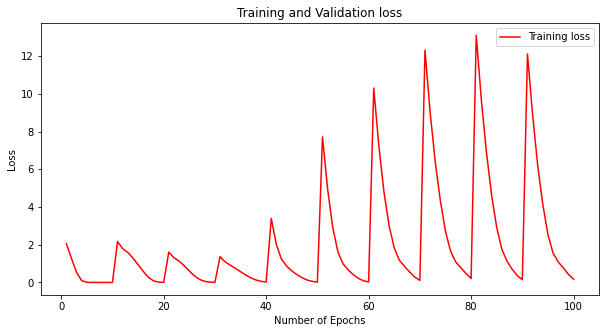

In [19]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,101)
plt.plot(epochs, cost, 'r', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

    

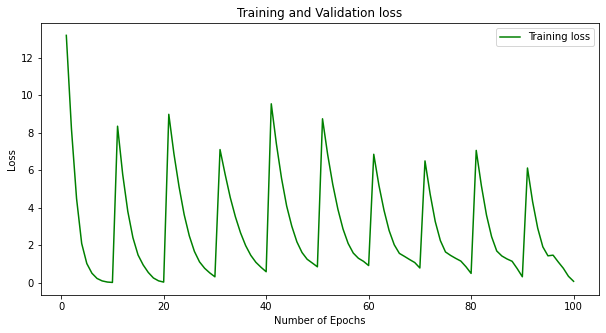

In [20]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,101)
plt.plot(epochs, valid_cost, 'g', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

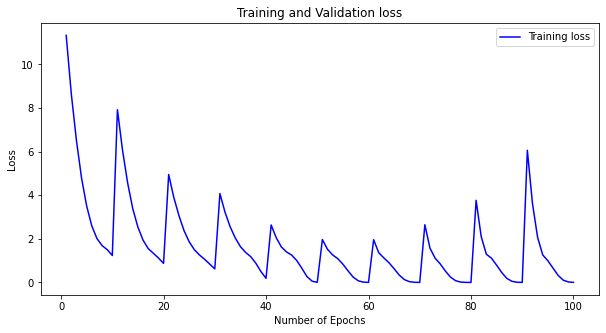

In [21]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,101)
plt.plot(epochs, test_cost, 'b', label='Training loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

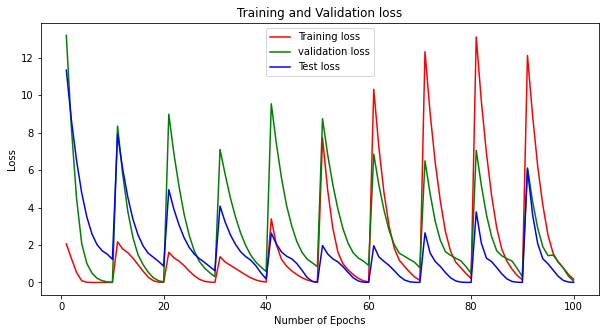

In [22]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
epochs = range(1,101)
plt.plot(epochs, cost, 'r', label='Training loss')
plt.plot(epochs, valid_cost, 'g', label='validation loss')
plt.plot(epochs, test_cost, 'b', label='Test loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

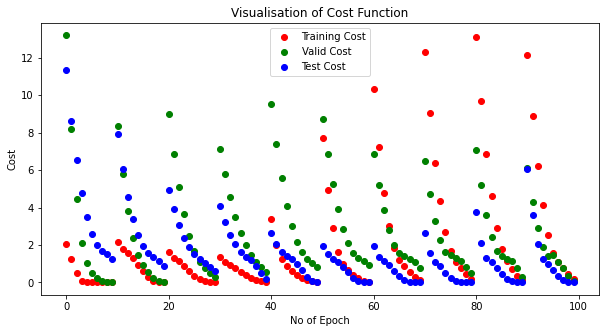

In [25]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
ax1.scatter(x=list(range(0,100)),y=cost,color='red',label='Training Cost')
ax1.scatter(x=list(range(0,100)),y=valid_cost,color='green',label='Valid Cost')
ax1.scatter(x=list(range(0,100)),y=test_cost,color='blue',label='Test Cost')
plt.xlabel('No of Epoch')
plt.ylabel('Cost')
plt.title('Visualisation of Cost Function')
plt.legend()
plt.show()

In [26]:
parameters = list(parameters)

In [27]:
parameters[1].shape

(5, 8, 5, 5)

In [28]:
parameters[0].shape

(8, 1, 5, 5)

In [29]:
parameters[2].shape

(128, 720)

In [30]:
type(parameters)

list

In [ ]:
parameters[2].dtype

In [31]:
from google.colab import files
uploaded = files.upload()

Saving MO_2221.jpg to MO_2221.jpg


In [32]:
image = cv2.imread('MO_2221.jpg',0)

In [33]:
image= cv2.resize(image,(32,32),interpolation = cv2.INTER_AREA)

In [34]:
type(image)

numpy.ndarray

In [35]:
image.shape

(32, 32)

In [36]:
image=np.reshape(image, (1,32,32))

In [37]:
image.shape

(1, 32, 32)

In [38]:
def test(image, label, params, conv_s, pool_f, pool_s):
    
    [f1, f2, w3, w4, b1, b2, b3, b4] = params 
    
    ################################################
    ############## Forward Operation ###############
    ################################################
    conv1 = convolution(image, f1, b1, conv_s) # convolution operation
    conv1[conv1<=0] = 0 # pass through ReLU non-linearity
    
    conv2 = convolution(conv1, f2, b2, conv_s) # second convolution operation
    conv2[conv2<=0] = 0 # pass through ReLU non-linearity
    
    pooled = maxpool(conv2, pool_f, pool_s) # maxpooling operation
    
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer
    
    z = w3.dot(fc) + b3 # first dense layer
    z[z<=0] = 0 # pass through ReLU non-linearity
    
    out = w4.dot(z) + b4 # second dense layer
     
    probs = softmax(out) # predict class probabilities with the softmax activation function
    
    ################################################
    #################### Loss ######################
    ################################################
    
    loss = categoricalCrossEntropy(probs, label) # categorical cross-entropy loss
        
        
    return probs, loss

In [39]:
prediction,loss = test(image, label=8, params = parameters, conv_s=1, pool_f=2, pool_s=2)

In [40]:
prediction

array([[2.30757953e-05],
       [8.18373402e-13],
       [9.37271555e-13],
       [1.98618572e-12],
       [1.63140168e-12],
       [8.19200912e-04],
       [9.99157723e-01],
       [1.78746580e-12]])

In [41]:
max(prediction)

array([0.99915772])

In [42]:
loss

1235.5889599969219

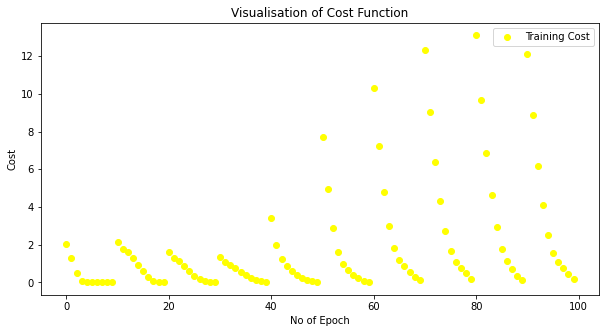

In [43]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)
ax1.scatter(x=list(range(0,100)),y=cost,color='yellow',label='Training Cost')
plt.xlabel('No of Epoch')
plt.ylabel('Cost')
plt.title('Visualisation of Cost Function')
plt.legend()
plt.show()

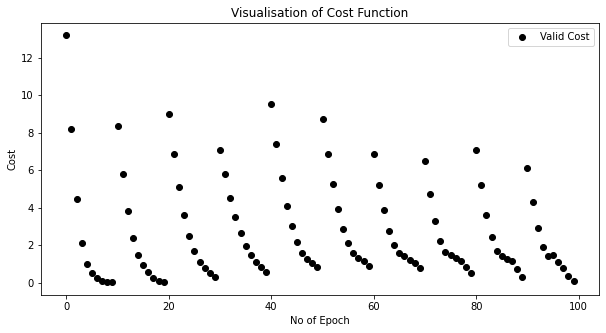

In [44]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)

ax1.scatter(x=list(range(0,100)),y=valid_cost,color='black',label='Valid Cost')

plt.xlabel('No of Epoch')
plt.ylabel('Cost')
plt.title('Visualisation of Cost Function')
plt.legend()
plt.show()

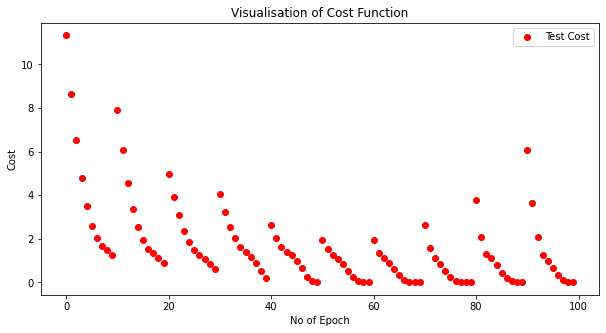

In [45]:
fig,(ax1)=plt.subplots(figsize=(10,5),
                          nrows=1,
                          ncols=1)

ax1.scatter(x=list(range(0,100)),y=test_cost,color='red',label='Test Cost')
plt.xlabel('No of Epoch')
plt.ylabel('Cost')
plt.title('Visualisation of Cost Function')
plt.legend()
plt.show()

In [ ]:
type(cost)


In [ ]:
import matplotlib.pyplot as plt

# Import 3D Axes
from mpl_toolkits.mplot3d import axes3d

In [ ]:
epochs = range(1,6)
plt.plot(epochs, cost, 'g', label='Training loss')
plt.plot(epochs, valid_cost, 'b', label='validation loss')
plt.plot(epochs, test_cost, 'r', label='Test loss')
plt.title('Training and Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()